# Classifier

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.enable_eager_execution()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load index csv

In [2]:
# TODO update dataset
dataset_index = pd.read_csv('./dataset/tiles-data/data.csv')
print(dataset_index.shape)
print(dataset_index.head())

dataset_size = dataset_index.shape[0]
num_classes = np.amax(dataset_index['label'])

# append path prefix
dataset_index['image-path'] = './dataset/tiles-resized/' + dataset_index['image-name']
print(dataset_index.shape)
print(dataset_index.head())

# shuffle
dataset_index = dataset_index.reindex(np.random.permutation(dataset_index.index))
print(dataset_index.shape)
print(dataset_index.head())

(629, 3)
  image-name  label    label-name
0      1.jpg     38  bonus-winter
1      2.jpg     26  characters-8
2      3.jpg      9        dots-9
3      4.jpg     36  bonus-summer
4      5.jpg     28   honors-east
(629, 4)
  image-name  label    label-name                     image-path
0      1.jpg     38  bonus-winter  ./dataset/tiles-resized/1.jpg
1      2.jpg     26  characters-8  ./dataset/tiles-resized/2.jpg
2      3.jpg      9        dots-9  ./dataset/tiles-resized/3.jpg
3      4.jpg     36  bonus-summer  ./dataset/tiles-resized/4.jpg
4      5.jpg     28   honors-east  ./dataset/tiles-resized/5.jpg
(629, 4)
    image-name  label    label-name                       image-path
128    129.jpg     24  characters-6  ./dataset/tiles-resized/129.jpg
408    409.jpg     12      bamboo-3  ./dataset/tiles-resized/409.jpg
37      38.jpg     30   honors-west   ./dataset/tiles-resized/38.jpg
387    388.jpg     28   honors-east  ./dataset/tiles-resized/388.jpg
347    348.jpg     27  characters-

## Load and rotate images

Instructions for updating:
Colocations handled automatically by placer.


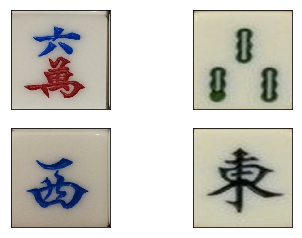

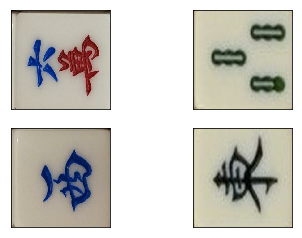

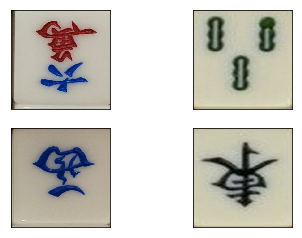

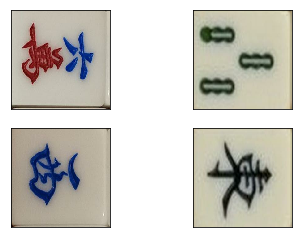

In [3]:
def show_image_sample(ds):
    for n,image in enumerate(ds.take(4)):
        plt.subplot(2,2,n+1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.show()

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [320, 320])
    image /= 255.0 # normalize to [0,1]
    return image

path_ds = tf.data.Dataset.from_tensor_slices(dataset_index['image-path'])
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds)

def rotate_image(image):
    image = tf.image.rot90(image)
    return image

image_ds_90 = image_ds.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_90)

image_ds_180 = image_ds_90.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_180)

image_ds_270 = image_ds_180.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_270)

dataset_size *= 4

## Create image-label pairs

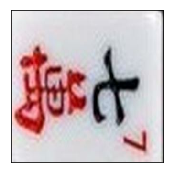

Tile class:
24


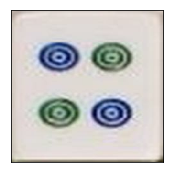

Tile class:
3


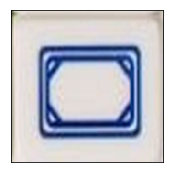

Tile class:
33


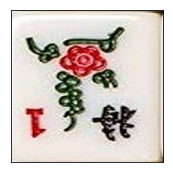

Tile class:
38
(TensorShape([Dimension(320), Dimension(320), Dimension(3)]), TensorShape([Dimension(42)]))


In [4]:
label_offset = tf.math.subtract(dataset_index['label'], 1) # Offset index by 1
label_one_shot = tf.one_hot(label_offset, num_classes)
image_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(label_one_shot, tf.int64))

all_image_ds = image_ds.concatenate(image_ds_90).concatenate(image_ds_180).concatenate(image_ds_270)
all_image_label_ds = image_label_ds.concatenate(image_label_ds).concatenate(image_label_ds).concatenate(image_label_ds)

all_ds = tf.data.Dataset.zip((all_image_ds, all_image_label_ds))
all_ds = all_ds.shuffle(dataset_size)

for n, (image, label) in enumerate(all_ds.take(4)):
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print("Tile class:")
    print(np.argmax(label))

print(all_ds.output_shapes)

## Split train test

In [5]:
# train-test split
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15) # test has 0.15 as well

print("train size:", train_size)
print("val size:", val_size)

train_ds = all_ds.take(train_size)
test_ds = all_ds.skip(train_size)
val_ds = test_ds.take(val_size)
test_ds = test_ds.skip(val_size)

train size: 1761
val size: 377


## Load Encoder

In [6]:
encoder = keras.Sequential(layers=[
    keras.layers.BatchNormalization(input_shape=(320,320,3)),

    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='selu'),
], name='encoder')

# Load weight
encoder.load_weights(filepath='./models/encoder.h5')

for layer in encoder.layers:
    layer.trainable = False

## FC

In [7]:
fc = keras.Sequential(layers=[
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='selu'),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(256, activation='selu'),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(128, activation='selu'),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(num_classes, activation='softmax')
], name='fc')

## Train the model

In [8]:
batch_size = 32

train_ds_batch = train_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=train_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)
val_ds_batch = val_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=val_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)

classifier = keras.Sequential([encoder, fc])
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# encoder.summary()
# fc.summary()
# classifier.summary()

train_history = classifier.fit(train_ds_batch.make_one_shot_iterator(),
               epochs=80,
               steps_per_epoch=int(train_size/batch_size),
               validation_data=val_ds_batch.make_one_shot_iterator(),
               validation_steps=int(val_size/batch_size),
               callbacks=[keras.callbacks.TensorBoard(log_dir='./logs')]
       )

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/80
Instructions for updating:
Use tf.cast instead.
55/55 [==============================] - 21s 381ms/step - loss: 12.6332 - acc: 0.0364 - val_loss: 4.4946 - val_acc: 0.0682
Epoch 2/80
55/55 [==============================] - 6s 114ms/step - loss: 5.7892 - acc: 0.0608 - val_loss: 3.2887 - val_acc: 0.1222
Epoch 3/80
55/55 [==============================] - 6s 114ms/step - loss: 4.3355 - acc: 0.0960 - val_loss: 2.9999 - val_acc: 0.1960
Epoch 4/80
55/55 [==============================] - 6s 115ms/step - loss: 3.8058 - acc: 0.1278 - val_loss: 2.7605 - val_acc: 0.2131
Epoch 5/80
55/55 [==============================] - 6s 115ms/step - loss: 3.4398 - acc: 0.1841 - val_loss: 2.5629 - val_acc: 0.2841
Epoch 6/80
55/55 [==============================] - 6s 115ms/step - loss: 3.2105 - acc: 0.2216 - val_loss: 2.0769 - val_acc: 0.3693
Epoch 7/80
55/55 [=========================

## Loss and accuracy graphs

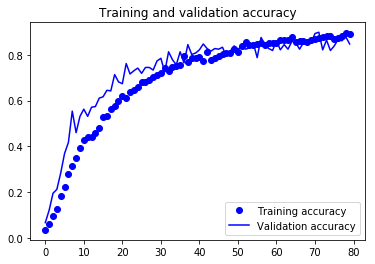

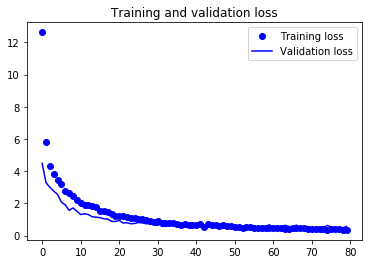

In [9]:
accuracy = train_history.history['acc']
val_accuracy = train_history.history['val_acc']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Evaluate

1/1 [==============================] - 6s 6s/step - loss: 0.3631 - acc: 0.9062


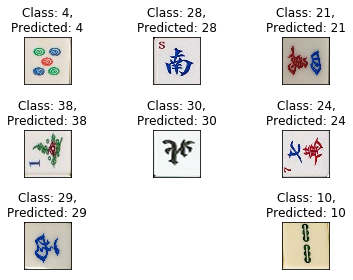

In [14]:
test_ds_batch = test_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=train_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)

classifier.evaluate(test_ds_batch.make_one_shot_iterator(), steps=1)

batch = test_ds_batch.skip(10).take(1)

for images, labels in batch:
    for i in range(9):
        plt.subplot(3, 3, i+1)
        image = images[i]
        label = labels[i]
        plt.imshow(image)
        plt.title("Class: {},\nPredicted: {}".format(np.argmax(label), np.argmax(classifier.predict(x=tf.data.Dataset.from_tensors([image]).make_one_shot_iterator(), steps=1))))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

## Save model

In [18]:
keras.models.save_model(
    model=classifier,
    filepath='./models/classifier.h5py',
    overwrite=True,
    include_optimizer=True
)

RuntimeError: Unable to create link (name already exists)